In [159]:
import os
import re
import keras
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from deepface import DeepFace
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [3]:
# load the model and the path of the dataset 
model = keras.models.load_model('ghostfacenet_v1.h5')
dataset_dir = 'lfw_dataset'

In [4]:
# get the list of persons
entities = [p for p in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, p)) and not p.startswith('.')]
random.shuffle(entities) 
print(f'The dataframe has a total of {len(entities)} entities')

The dataframe has a total of 5749 entities


Identificazione 1:N

Open set: 
E’ possibile che molti probes sottomessi al sistema non appartengono a nessun soggetto presente nel gallery. Il sistema deve prima capire se il soggetto è uno sconosciuto o no e poi nel caso verificarne l’identità.

Enrolled persons 注册过的人: has more 3 images

unenrolled_persons: has less images

Genuine Probes: Questi sono tentativi di accesso in cui i dati biometrici presentati al sistema sono effettivamente quelli della persona che afferma di essere. In altre parole, quando un utente autorizzato cerca di accedere al sistema usando i propri dati biometrici veri, si parla di "genuine probes". Questo tipo di prova è usato per verificare l'efficacia del sistema nel riconoscere correttamente gli utenti legittimi.

Impostor Probes: A differenza delle genuine probes, le impostor probes sono tentativi di accesso dove i dati biometrici usati sono quelli di una persona diversa da quella che sta effettuando il tentativo. Questo può includere sia situazioni in cui una persona cerca di ingannare il sistema usando i dati biometrici di un'altra persona, sia tentativi di accesso non autorizzati utilizzando dati rubati o falsificati. Queste prove sono cruciali per testare la sicurezza del sistema contro accessi fraudolenti.

In [5]:
data = []
min_num_photo_for_person = 3
max_num_photo_for_person = 6

for person in entities:
    person_dir = os.path.join(dataset_dir, person) # Entity path
    images_path = os.listdir(person_dir) # Entity photos
    random.shuffle(images_path)
    count = 0
    for image in images_path:   
        img_path = os.path.join(person_dir, image)
        result = DeepFace.extract_faces(img_path=img_path, enforce_detection=False)
        # Remove image which can't detect the face
        if result[0]['confidence'] != 0 and count <= max_num_photo_for_person:
            if len(images_path) >= min_num_photo_for_person:
                data.append([person, img_path, 'Genuine'])
            else: 
                data.append([person, img_path, 'Impostor'])
        count += 1


In [6]:
df = pd.DataFrame(data, columns=['Person', 'Image_Path', 'Label'])
df.head()

,Person,Image_Path,Label
0,Gianna_Angelopoulos-Daskalaki,lfw_dataset/Gianna_Angelopoulos-Daskalaki/Gian...,Genuine
1,Gianna_Angelopoulos-Daskalaki,lfw_dataset/Gianna_Angelopoulos-Daskalaki/Gian...,Genuine
2,Gianna_Angelopoulos-Daskalaki,lfw_dataset/Gianna_Angelopoulos-Daskalaki/Gian...,Genuine
3,Vitali_Klitschko,lfw_dataset/Vitali_Klitschko/Vitali_Klitschko_...,Genuine
4,Vitali_Klitschko,lfw_dataset/Vitali_Klitschko/Vitali_Klitschko_...,Genuine


In [7]:
print(f'The dataframe has a total of {df.shape[0]} images')
print(f"The dataframe has {(df['Label'] == 'Genuine').sum()} Genuine Probes")
print(f"The dataframe has {(df['Label'] == 'Impostor').sum()} Impostor Probes")

The dataframe has a total of 9633 images
The dataframe has 4180 Genuine Probes
The dataframe has 5453 Impostor Probes


In [8]:
person_genuine = set(df[df['Label'] == 'Genuine']['Person'].tolist())
print(f'The dataframe has a total of {len(person_genuine)} Enrolled entities')

person_impostor = set(df[df['Label'] == 'Impostor']['Person'].tolist())
print(f'The dataframe has a total of {len(person_impostor)} Not Enrolled entities')

The dataframe has a total of 901 Enrolled entities
The dataframe has a total of 4717 Not Enrolled entities


### reduce the entities to 20

In [9]:
selected_genuine = np.random.choice(list(person_genuine), 20, replace=False)

filtered_impostor_df = df[df['Person'].isin(selected_genuine)]
final_df = pd.concat([filtered_impostor_df, df[df['Label'] == 'Impostor']])

print(f"Total impostors in the new dataframe: {final_df[final_df['Label'] == 'Impostor']['Person'].nunique()}")
print(f"Total enrolled in the new dataframe: {final_df[final_df['Label'] == 'Genuine']['Person'].nunique()}")

print(f"The new dataframe has {(final_df['Label'] == 'Genuine').sum()} Genuine Probes")
print(f"The new dataframe has {(final_df['Label'] == 'Impostor').sum()} Impostor Probes")

Total impostors in the new dataframe: 4717
Total enrolled in the new dataframe: 20
The new dataframe has 95 Genuine Probes
The new dataframe has 5453 Impostor Probes


In [10]:
selected_impostors = np.random.choice(list(person_impostor), 20, replace=False)

filtered_impostor_df = final_df[final_df['Person'].isin(selected_impostors)]
final_df1 = pd.concat([filtered_impostor_df, final_df[final_df['Label'] == 'Genuine']])

print(f"Total impostors in the new dataframe: {final_df1[final_df1['Label'] == 'Impostor']['Person'].nunique()}")
print(f"Total enrolled in the new dataframe: {final_df1[final_df1['Label'] == 'Genuine']['Person'].nunique()}")

print(f"The new dataframe has {(final_df1['Label'] == 'Genuine').sum()} Genuine Probes")
print(f"The new dataframe has {(final_df1['Label'] == 'Impostor').sum()} Impostor Probes")

Total impostors in the new dataframe: 20
Total enrolled in the new dataframe: 20
The new dataframe has 95 Genuine Probes
The new dataframe has 23 Impostor Probes


In [13]:
final_df1.head()

,Person,Image_Path,Label
527,Muammar_Gaddafi,lfw_dataset/Muammar_Gaddafi/Muammar_Gaddafi_00...,Impostor
528,Muammar_Gaddafi,lfw_dataset/Muammar_Gaddafi/Muammar_Gaddafi_00...,Impostor
549,Evelyn_Lauder,lfw_dataset/Evelyn_Lauder/Evelyn_Lauder_0001.jpg,Impostor
860,Cliff_Ellis,lfw_dataset/Cliff_Ellis/Cliff_Ellis_0001.jpg,Impostor
1761,Joe_Vandever,lfw_dataset/Joe_Vandever/Joe_Vandever_0001.jpg,Impostor


In [14]:
final_df1.to_csv('image_genuine_impostor.csv', index=False)

crea la matrice ALL-against-ALL approach


## da qui load csv e run e crea la matrice con la distanza

In [15]:
final_df1 = pd.read_csv('image_genuine_impostor.csv')

In [16]:
gallery = final_df1[final_df1['Label'] == 'Genuine']['Image_Path'].tolist() # colonne
probes = final_df1['Image_Path'].tolist() # righe

In [ ]:
print(gallery)
print(len(gallery))

In [ ]:
print(probes)
print(len(probes))

11 gallery x 13 probes =  143objects 24.8s 
95 x 118 = 10,030 30m

In [19]:
distances = []

for img2_path in probes:
    distances_row = []
    for img1_path in gallery:
        result = DeepFace.verify(img1_path=img1_path, img2_path = img2_path, model_name = 'GhostFaceNet')
        distances_row.append(result['distance'])
    distances.append(distances_row)

In [20]:
df_distanze = pd.DataFrame(distances, index=probes, columns=gallery)

In [21]:
df_distanze.head()

,lfw_dataset/Bob_Dole/Bob_Dole_0003.jpg,lfw_dataset/Bob_Dole/Bob_Dole_0001.jpg,lfw_dataset/Bob_Dole/Bob_Dole_0002.jpg,lfw_dataset/Mark_Hurlbert/Mark_Hurlbert_0003.jpg,lfw_dataset/Mark_Hurlbert/Mark_Hurlbert_0005.jpg,lfw_dataset/Mark_Hurlbert/Mark_Hurlbert_0001.jpg,lfw_dataset/Mark_Hurlbert/Mark_Hurlbert_0002.jpg,lfw_dataset/Mark_Hurlbert/Mark_Hurlbert_0004.jpg,lfw_dataset/Abdullah_al-Attiyah/Abdullah_al-Attiyah_0002.jpg,lfw_dataset/Abdullah_al-Attiyah/Abdullah_al-Attiyah_0003.jpg,...,lfw_dataset/Roy_Williams/Roy_Williams_0004.jpg,lfw_dataset/Mahathir_Mohamad/Mahathir_Mohamad_0006.jpg,lfw_dataset/Mahathir_Mohamad/Mahathir_Mohamad_0005.jpg,lfw_dataset/Mahathir_Mohamad/Mahathir_Mohamad_0007.jpg,lfw_dataset/Mahathir_Mohamad/Mahathir_Mohamad_0001.jpg,lfw_dataset/Mahathir_Mohamad/Mahathir_Mohamad_0004.jpg,lfw_dataset/Mahathir_Mohamad/Mahathir_Mohamad_0014.jpg,lfw_dataset/Jim_Carrey/Jim_Carrey_0002.jpg,lfw_dataset/Jim_Carrey/Jim_Carrey_0003.jpg,lfw_dataset/Jim_Carrey/Jim_Carrey_0001.jpg
lfw_dataset/Muammar_Gaddafi/Muammar_Gaddafi_0002.jpg,1.075806,1.063287,1.094025,1.003199,0.897616,0.965774,0.909154,0.988448,1.034994,1.026336,...,1.027628,1.072138,1.009884,1.025072,1.009960,0.910514,1.004082,0.915453,0.862646,0.926291
lfw_dataset/Muammar_Gaddafi/Muammar_Gaddafi_0001.jpg,1.035444,1.044940,1.043981,0.922984,0.949242,0.950999,0.952447,0.965264,1.020002,1.056516,...,1.020662,1.041932,1.067459,1.074492,1.023869,1.030236,1.069680,0.870167,0.932215,0.922480
lfw_dataset/Evelyn_Lauder/Evelyn_Lauder_0001.jpg,0.974692,0.877558,1.075005,0.862793,1.026364,1.002694,0.938094,0.841655,0.971888,0.964937,...,0.967545,0.973839,0.972815,0.973017,0.934180,1.033668,0.988440,1.043755,1.126394,1.074762
lfw_dataset/Cliff_Ellis/Cliff_Ellis_0001.jpg,0.977382,1.055060,0.925123,1.065828,0.957008,1.031279,1.022949,1.147830,1.013310,1.000425,...,0.868258,0.915397,0.996200,0.822989,0.901488,0.960033,0.998585,0.994863,0.915256,1.136081
lfw_dataset/Joe_Vandever/Joe_Vandever_0001.jpg,1.127945,1.136793,1.071955,0.855035,1.000085,0.930563,0.914672,0.866745,0.909297,1.013839,...,0.892475,0.918978,0.877298,0.768450,0.711020,0.896121,0.842975,0.887773,1.101188,1.003043


In [22]:
print(df_distanze.shape[0])

118


In [24]:
df_distanze.to_csv('distance_matrix.csv')

----- sopra ok ----- crea matrice

Nel contesto dei sistemi biometrici, il threshold (soglia) è un valore critico utilizzato per decidere se due campioni biometrici (ad esempio, impronte digitali, riconoscimento facciale, ecc.) provengono dalla stessa persona o no. La decisione si basa sul confronto di una misura di similarità o distanza tra i campioni contro questo valore di soglia.

In [97]:
df_distanze = pd.read_csv('distance_matrix.csv', index_col=0)

In [98]:
df_distanze.head()

,lfw_dataset/Bob_Dole/Bob_Dole_0003.jpg,lfw_dataset/Bob_Dole/Bob_Dole_0001.jpg,lfw_dataset/Bob_Dole/Bob_Dole_0002.jpg,lfw_dataset/Mark_Hurlbert/Mark_Hurlbert_0003.jpg,lfw_dataset/Mark_Hurlbert/Mark_Hurlbert_0005.jpg,lfw_dataset/Mark_Hurlbert/Mark_Hurlbert_0001.jpg,lfw_dataset/Mark_Hurlbert/Mark_Hurlbert_0002.jpg,lfw_dataset/Mark_Hurlbert/Mark_Hurlbert_0004.jpg,lfw_dataset/Abdullah_al-Attiyah/Abdullah_al-Attiyah_0002.jpg,lfw_dataset/Abdullah_al-Attiyah/Abdullah_al-Attiyah_0003.jpg,...,lfw_dataset/Roy_Williams/Roy_Williams_0004.jpg,lfw_dataset/Mahathir_Mohamad/Mahathir_Mohamad_0006.jpg,lfw_dataset/Mahathir_Mohamad/Mahathir_Mohamad_0005.jpg,lfw_dataset/Mahathir_Mohamad/Mahathir_Mohamad_0007.jpg,lfw_dataset/Mahathir_Mohamad/Mahathir_Mohamad_0001.jpg,lfw_dataset/Mahathir_Mohamad/Mahathir_Mohamad_0004.jpg,lfw_dataset/Mahathir_Mohamad/Mahathir_Mohamad_0014.jpg,lfw_dataset/Jim_Carrey/Jim_Carrey_0002.jpg,lfw_dataset/Jim_Carrey/Jim_Carrey_0003.jpg,lfw_dataset/Jim_Carrey/Jim_Carrey_0001.jpg
lfw_dataset/Muammar_Gaddafi/Muammar_Gaddafi_0002.jpg,1.075806,1.063287,1.094025,1.003199,0.897616,0.965774,0.909154,0.988448,1.034994,1.026336,...,1.027628,1.072138,1.009884,1.025072,1.009960,0.910514,1.004082,0.915453,0.862646,0.926291
lfw_dataset/Muammar_Gaddafi/Muammar_Gaddafi_0001.jpg,1.035444,1.044940,1.043981,0.922984,0.949242,0.950999,0.952447,0.965264,1.020002,1.056516,...,1.020662,1.041932,1.067459,1.074492,1.023869,1.030236,1.069680,0.870167,0.932215,0.922480
lfw_dataset/Evelyn_Lauder/Evelyn_Lauder_0001.jpg,0.974692,0.877558,1.075005,0.862793,1.026364,1.002694,0.938094,0.841655,0.971888,0.964937,...,0.967545,0.973839,0.972815,0.973017,0.934180,1.033668,0.988440,1.043755,1.126394,1.074762
lfw_dataset/Cliff_Ellis/Cliff_Ellis_0001.jpg,0.977382,1.055060,0.925123,1.065828,0.957008,1.031279,1.022949,1.147830,1.013310,1.000425,...,0.868258,0.915397,0.996200,0.822989,0.901488,0.960033,0.998585,0.994863,0.915256,1.136081
lfw_dataset/Joe_Vandever/Joe_Vandever_0001.jpg,1.127945,1.136793,1.071955,0.855035,1.000085,0.930563,0.914672,0.866745,0.909297,1.013839,...,0.892475,0.918978,0.877298,0.768450,0.711020,0.896121,0.842975,0.887773,1.101188,1.003043


In [99]:
print(df_distanze.shape[1]) # colonne gallery
print(df_distanze.shape[0]) # righe probes

95
118


In [100]:
len(set(final_df1['Person'].tolist()))

40

In [ ]:
for probe_index in range(0, df_distanze.shape[0]-1):
    probe_subject = df_distanze.iloc[probe_index]
    
    for gallery_index in range(0, df_distanze.shape[1]-1):
        distance = df_distanze.iloc[probe_index][gallery_index]
        probe_subject = df_distanze.index[probe_index]
        gallery_subject = df_distanze.columns[gallery_index]
        

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # print all first row with column label
    print(df_distanze.iloc[0])

In [ ]:
distances = df_distanze.iloc[0].values  # Distances for current probe
sorted_indices = np.argsort(distances)   # Indices of gallery sorted by distance

#print(distances)
#print(sorted_indices)
print(distances[sorted_indices[0]])
print(df_distanze.iloc[0].index[sorted_indices[0]])

In [ ]:
threshold = 1.00
probe_index = 0

probe = df_distanze.index[probe_index]
print(probe)

In [ ]:
for value_index in range(1, len(sorted_indices)-1):
    if distances[sorted_indices[value_index]] <= threshold:
        print("value index", value_index, sorted_indices[value_index],  distances[sorted_indices[value_index]])
        if probe != df_distanze.iloc[probe_index].index[sorted_indices[value_index]]:
            print(df_distanze.iloc[probe_index].index[sorted_indices[value_index]], "hi")

In [246]:
def is_impostor(df, image_path):
    if image_path in df['Image_Path'].values:
        row = df[df['Image_Path'] == image_path].iloc[0]
        # Check if the label is 'Genuine'
        if row['Label'] == 'Impostor':
            return True
    return False

In [160]:
def extract_middle_part(string):
    # Use regular expression to extract the middle part
    match = re.search(r'(?<=/)\w+(?=/)', string)
    if match:
        return match.group(0)
    else:
        return None

In [233]:
def all_against_all(df_distanze):
    thresholds = [round(threshold, 2) for threshold in np.arange(0.01, 1.0, 0.01)] 
    thresholds.sort()

    total_genuine_attempts = df_distanze.shape[1]
    total_impostor_attempts = (final_df1['Label'] == 'Impostor').sum()

    evaluation_metrics = {
        "number_of_subjects": len(set(final_df1['Person'].tolist())),
        "number_of_impostors": total_impostor_attempts,
        "number_of_subjects_in_gallery": (final_df1['Label'] == 'Genuine').sum(),
        "total_number_of_gallery_samples": df_distanze.shape[1],
        "total_number_of_probe_samples": df_distanze.shape[0],
        "total_genuine_attempts": total_genuine_attempts,
        "thresholds": list()
    }
    
    for threshold in thresholds:
        threshold_metrics = {
            "DI": 0,  # Direct Identifications
            "FA": 0,  # False Accepts
            "GR": 0,  # Genuine Rejects
            "FR": 0,  # False Rejects
            "DIR": dict(),  # Direct Identification Rate
            "FRR": 0,  # False Reject Rate
            "FAR": 0,  # False Accept Rate
            "GRR": 0  # Genuine Reject Rate
        }

        for probe_index in range(df_distanze.shape[0]):  # Iterate through probe samples
            distances = df_distanze.iloc[probe_index].values  # Distances for current probe
            sorted_indices = np.argsort(distances)  # Indices of gallery sorted by distance

            #print(distances, sorted_indices)
            impostor = is_impostor(final_df1, df_distanze.index[probe_index])
            if not impostor:
                # is genuine
                # print(df_distanze.index[probe_index],distances, sorted_indices)
                sorted_indices = sorted_indices[1:]  # Remove first index (genuine)

            probe = df_distanze.index[probe_index]  # The index (row labels) of the DataFrame.
            probe_name = extract_middle_part(probe)
            first_gallery = df_distanze.iloc[probe_index].index[sorted_indices[0]] # The index (column labels) of the DataFrame.
            first_gallery_name = extract_middle_part(first_gallery)

            smallest_distance = distances[sorted_indices[0]]
            is_accepted_value = smallest_distance <= threshold

            if is_accepted_value:
                if probe_name == first_gallery_name:
                    # if are same image
                    threshold_metrics["DI"] += 1 # Direct Identifications
                    #if not impostor:
                    #    for value_index in range(1, len(sorted_indices)): # ciclo sulla lista delle distanze partendo da secondo elemento
                    #        if distances[sorted_indices[value_index]] <= threshold: # se valore è piccolo di threshold
                    #            gallery_name = extract_middle_part(df_distanze.iloc[probe_index].index[sorted_indices[value_index]])
                    #            if probe_name != gallery_name: # se sono due immagini differenti
                    #                print('entrato')
                    #                threshold_metrics["FA"] += 1
                    #                total_impostor_attempts += 1
                    #                break
                    #        else:
                    #           break
                else:
                    if not impostor:
                        for value_index in range(1, len(sorted_indices)-1): # ciclo sulla lista delle distanze partendo da secondo elemento
                            if distances[sorted_indices[value_index]] <= threshold: # se valore è piccolo di threshold
                                gallery_name = extract_middle_part(df_distanze.iloc[probe_index].index[sorted_indices[value_index]])
                                if probe == gallery_name: # se sono due immagini differenti
                                    threshold_metrics["DI"] += 1
                                    break
                            else:
                                break
                    else:
                        threshold_metrics["FA"] += 1 # False Accepts Quando un soggetto impostore viene accettato
            else:
                # threshold is greater than the accepted_value
                if impostor:
                    # Genuine Rejects Quando un soggetto impostore viene rifiutato
                    threshold_metrics["GR"] += 1
                else:
                    # False Rejects Quando l’identità dichiarata è vera ma il soggetto viene rifiutato
                    threshold_metrics["FR"] += 1

        threshold_metrics["DIR"] = threshold_metrics["DI"] / total_genuine_attempts
        threshold_metrics["FAR"] = threshold_metrics["FA"] / total_impostor_attempts  # Total impostor comparisons
        threshold_metrics["GRR"] = threshold_metrics["GR"] / total_impostor_attempts
        threshold_metrics["FRR"] = 1 - threshold_metrics["DIR"] # False Reject Rate
        evaluation_metrics["thresholds"].append({threshold: threshold_metrics})

    return evaluation_metrics

In [234]:
evaluation_metrics = all_against_all(df_distanze)

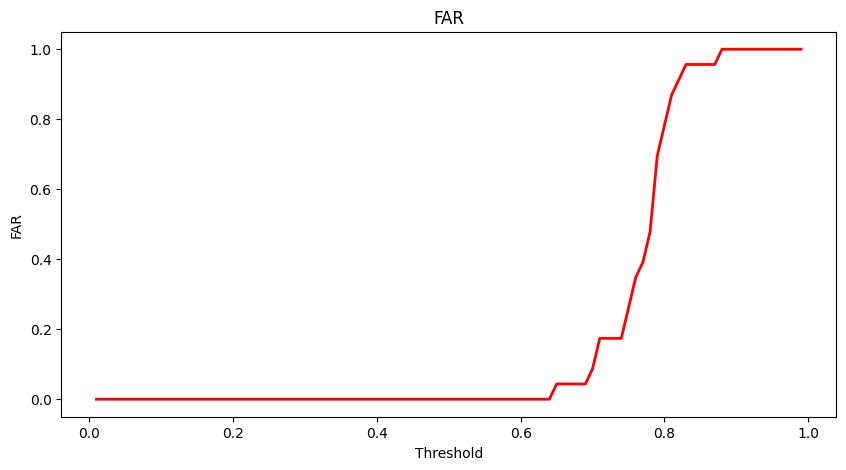

In [235]:
far_values = [metrics[list(metrics.keys())[0]]['FAR'] for metrics in evaluation_metrics['thresholds']]
thresholds = [list(metrics.keys())[0] for metrics in evaluation_metrics['thresholds']]

# Plot FAR against Thresholds with the corrected logic
plt.figure(figsize=(10, 5))
plt.plot(thresholds, far_values, 'r', lw=2)  # Adding line width for better visibility
plt.title('FAR')
plt.xlabel('Threshold')
plt.ylabel('FAR')
#plt.ylim([0,1])  # Set the limits of the y-axis to ensure it is between 0 and 1
plt.show()

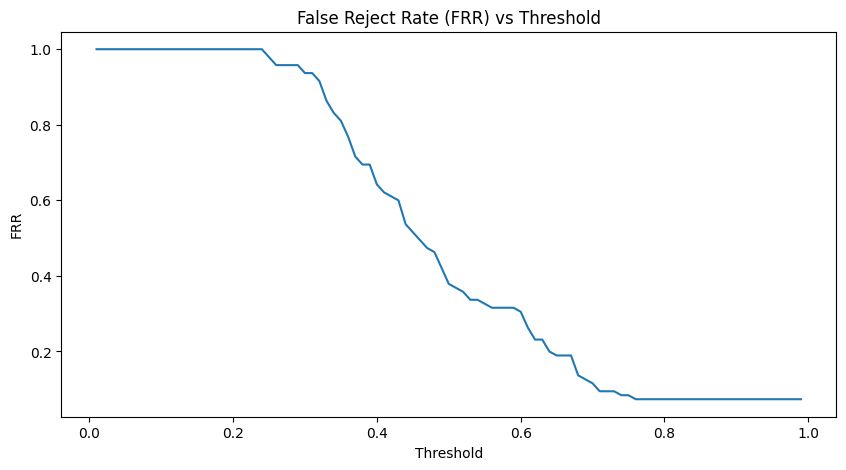

In [236]:
frr_values = [metrics[list(metrics.keys())[0]]['FRR'] for metrics in evaluation_metrics['thresholds']]

# Plot FAR against Thresholds
plt.figure(figsize=(10, 5))
plt.plot(thresholds, frr_values)
plt.title('False Reject Rate (FRR) vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('FRR')
plt.show()

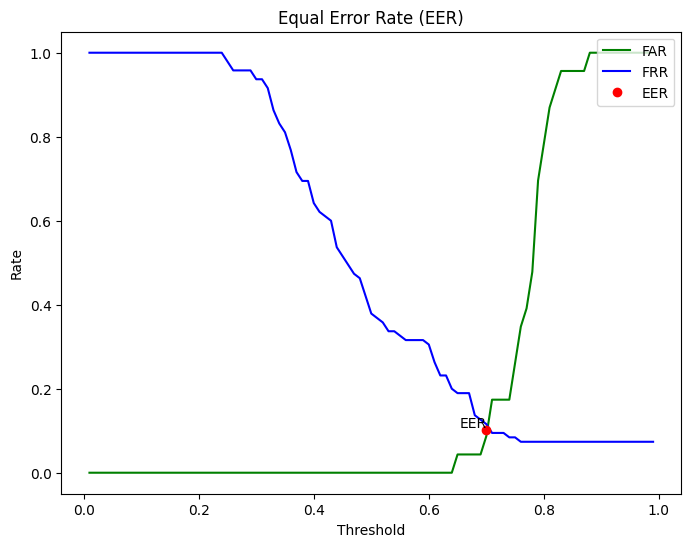

In [239]:
diffs = [abs(fa - fr) for fa, fr in zip(far_values, frr_values)]
eer_index = diffs.index(min(diffs))
eer_threshold = thresholds[eer_index]
eer_value = (far_values[eer_index] + frr_values[eer_index]) / 2

# Plot FAR and FRR against thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, far_values, linestyle='-', color='g', label='FAR')
plt.plot(thresholds, frr_values, linestyle='-', color='b', label='FRR')
plt.plot(eer_threshold, eer_value, 'ro', label='EER')
plt.text(eer_threshold, eer_value, 'EER', color='black', ha='right', va='bottom')

# Setting up the plot
plt.title('Equal Error Rate (EER)')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend(loc='upper right')
plt.show()

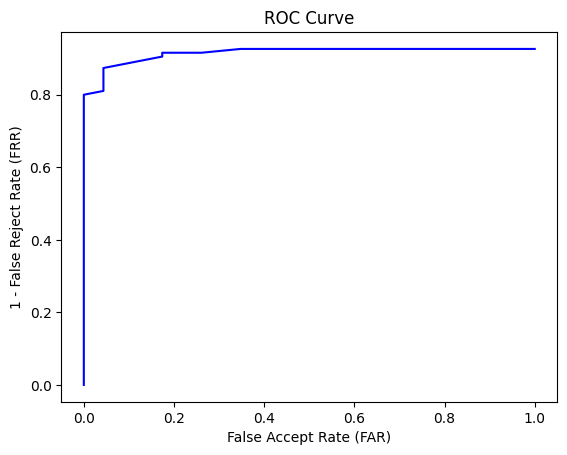

In [240]:
tpr_values = [1 - frr for frr in frr_values]  # TPR is 1 - FRR


plt.figure()
plt.plot(far_values, tpr_values, linestyle='-', color='b')
plt.title('ROC Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('1 - False Reject Rate (FRR)')
plt.show()

In [242]:
from scipy.stats import norm

([<matplotlib.axis.YTick at 0x359b4dc10>,
 [Text(0, 0.01, '0.01'), Text(0, 0.1, '0.1'), Text(0, 1.0, '1')])

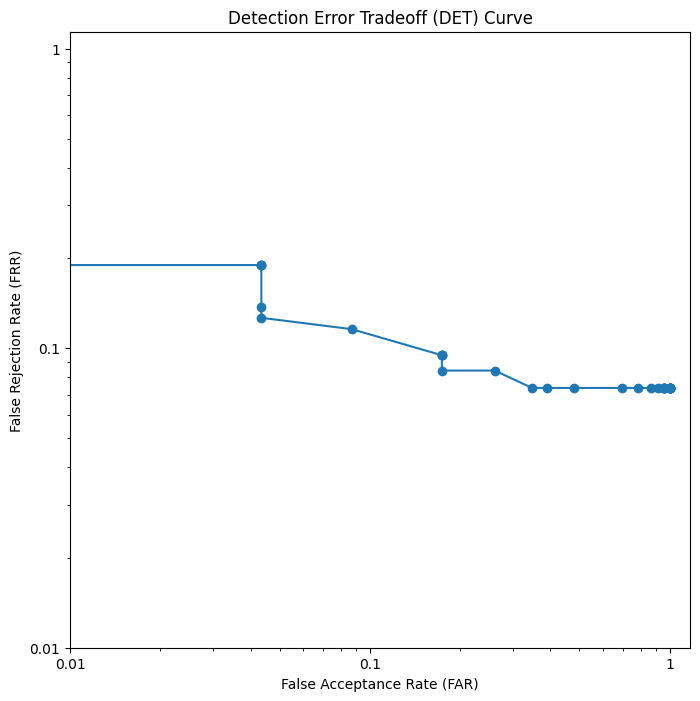

In [245]:
# Plotting the DET curve
plt.figure(figsize=(8, 8))
plt.plot(far_values, frr_values, marker='o', linestyle='-')
plt.title('Detection Error Tradeoff (DET) Curve')
plt.xlabel('False Acceptance Rate (FAR)')
plt.ylabel('False Rejection Rate (FRR)')
plt.xscale('log')  # Optionally use logarithmic scale for better visualization
plt.yscale('log')  # Optionally use logarithmic scale for better visualization
#plt.xticks([0.01, 0.1, 1], ['0.01', '0.1', '1'])
#plt.yticks([0.01, 0.1, 1], ['0.01', '0.1', '1'])



--------- sotto no ---------

In [8]:
def generate_pairs(df):
    """Generate all possible genuine pairs and then randomly select impostor pairs to match the number of genuine pairs."""
    genuine_pairs = []
    impostor_pairs = []

    # Generate genuine pairs
    for _, group in df.groupby('Person'):
        genuine_pairs.extend(list(combinations(group['Image_Path'], 2)))

    num_genuine_pairs = len(genuine_pairs)
    unique_person_ids = df['Person'].unique()

    while len(impostor_pairs) < num_genuine_pairs:
        # Randomly select two different persons
        person_a, person_b = random.sample(list(unique_person_ids), 2)

        # Randomly select an image from each person
        path_a = random.choice(df[df['Person'] == person_a]['Image_Path'].tolist())
        path_b = random.choice(df[df['Person'] == person_b]['Image_Path'].tolist())

        # Add this impostor pair to the list
        impostor_pairs.append((path_a, path_b))

    return genuine_pairs, impostor_pairs

In [9]:
genuine_pairs, impostor_pairs = generate_pairs(df)

In [10]:
print(len(genuine_pairs), len(impostor_pairs))

236044 236044


In [19]:
def get_embedding(model, image_path):
    """
    Get an image embedding using ghostfacenet_v1 model.
    
    Parameters:
    - image_path: Path to the image file.
    
    Returns:
    - embedding: The embedding vector for the image.
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize((112, 112))
    img_array = np.array(img).astype('float32')
    
    # Normalize the image data to [-1, 1]
    img_array = (img_array / 127.5) - 1  # Assuming the original range is [0, 255]
    return model.predict(np.expand_dims(img_array, axis=0))


def compute_cosine_distance(features1, features2):
    # Compute and return the cosine distance between two feature vectors
    return cosine_similarity(features1, features2)

def compute_distances(pairs, model):
    """Compute the cosine distance for each pair, handling NaN values."""
    distances = []
    for img_path_a, img_path_b in pairs:

        embedding1 = get_embedding(model, img_path_a)
        embedding2 = get_embedding(model, img_path_b)

        if embedding1 is None or embedding2 is None:
            print(f"Skipping pair {img_path_a}, {img_path_b} due to an error.")
            continue
        # Ensure no NaN values are present in features before computing distance
        if np.isnan(embedding1).any() or np.isnan(embedding2).any():
            print(f"Found NaN in features for pair {img_path_a}, {img_path_b}. Skipping.")
            continue
        # Compute cosine similarity and convert it to distance
        similarity = cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))
        distance = 1 - similarity.item()  # Convert numpy array to scalar
        print(f"Distance between {img_path_a} and {img_path_b}: {distance}")
        distances.append(distance)
    return distances

In [ ]:
genuine_distances = compute_distances(genuine_pairs, model)

In [ ]:
impostor_distances = compute_distances(impostor_pairs, model)

In [26]:
def evaluate_threshold(distances, threshold):
    """Evaluate pairs against the threshold to determine matches and non-matches."""
    matches = [distance <= threshold for distance in distances]
    return matches

def calculate_metrics(genuine_distances, impostor_distances, threshold):
    """Calculate evaluation metrics based on distances and a threshold."""
    genuine_matches = evaluate_threshold(genuine_distances, threshold)
    impostor_matches = evaluate_threshold(impostor_distances, threshold)

    # True Positive: Genuine pair correctly matched
    tp = sum(genuine_matches)
    # False Positive: Impostor pair incorrectly matched
    fp = sum(impostor_matches)
    # True Negative: Impostor pair correctly not matched
    tn = len(impostor_matches) - fp
    # False Negative: Genuine pair incorrectly not matched
    fn = len(genuine_matches) - tp

    # Example metric calculations
    far = fp / (fp + tn)  # False Acceptance Rate
    frr = fn / (fn + tp)  # False Rejection Rate

    return {'FAR': far, 'FRR': frr}

In [27]:
# Main evaluation
thresholds = np.arange(0.01, 1.0, 0.01)
results = {}

for threshold in thresholds:
    metrics = calculate_metrics(genuine_distances, impostor_distances, threshold)
    results[threshold] = metrics

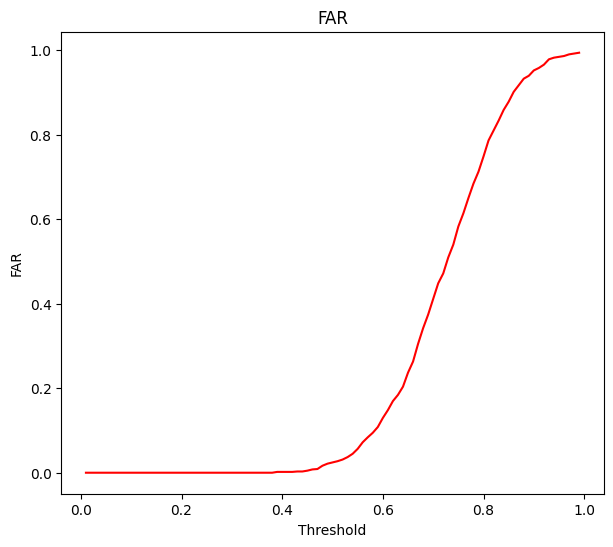

In [28]:
thresholds = [key for key in results.keys()]
far = [results[thresh]['FAR'] for thresh in thresholds]

plt.figure(figsize=(7, 6)) 
plt.plot(thresholds, far, linestyle='-', color='r')
plt.title('FAR')
plt.xlabel('Threshold')
plt.ylabel('FAR')
plt.show()

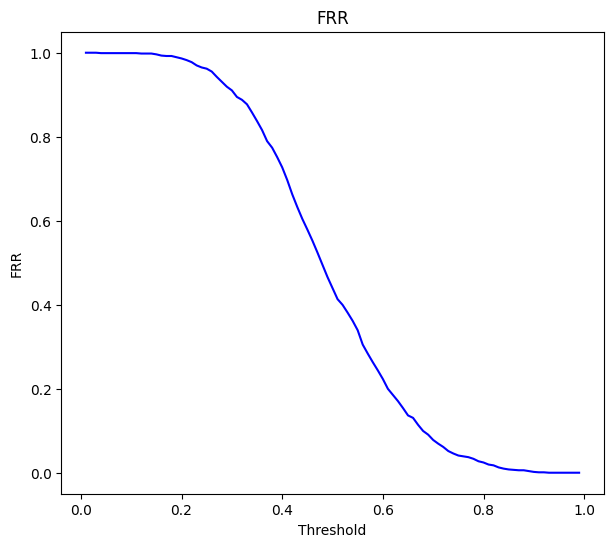

In [29]:
frr = [results[thresh]['FRR'] for thresh in thresholds]
plt.figure(figsize=(7, 6))
plt.plot(thresholds, frr, linestyle='-', color='b')
plt.title('FRR')
plt.xlabel('Threshold')
plt.ylabel('FRR')
plt.show()

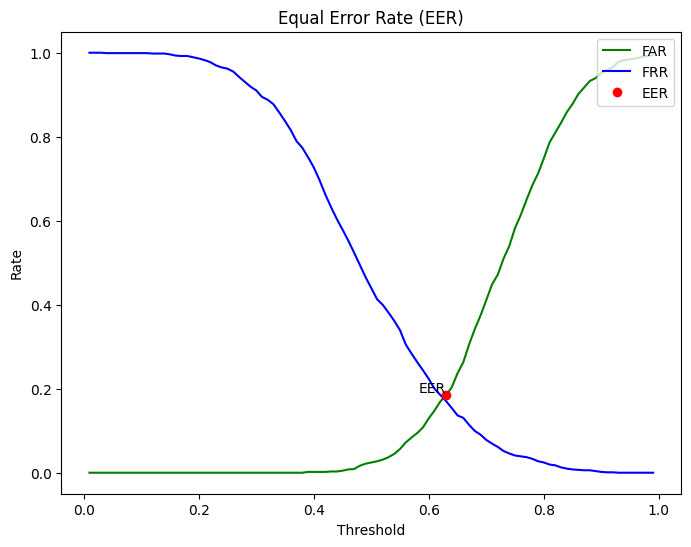

In [30]:
eer_index = np.argmin(np.abs(np.array(far) - np.array(frr)))
eer_FAR = far[eer_index]
eer_threshold = thresholds[eer_index]

# Plot FAR and FRR against thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, far, linestyle='-', color='g', label='FAR')
plt.plot(thresholds, frr, linestyle='-', color='b', label='FRR')
plt.plot(eer_threshold, eer_FAR, 'ro', label='EER')
plt.text(eer_threshold, eer_FAR, 'EER', color='black', ha='right', va='bottom')

# Setting up the plot
plt.title('Equal Error Rate (EER)')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend(loc='upper right')
plt.show()

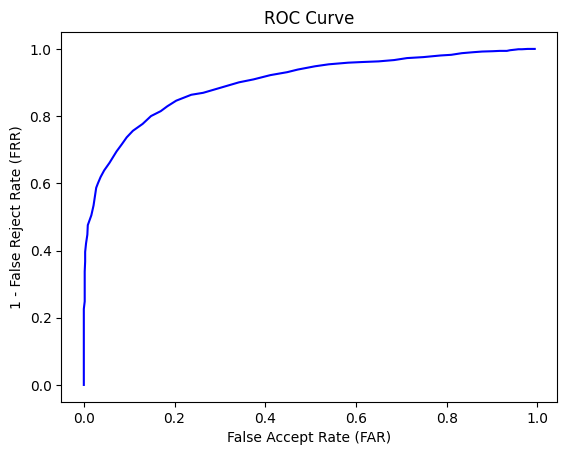

In [31]:
frr1 = [1-results[thresh]['FRR'] for thresh in thresholds]


plt.figure()
plt.plot(far, frr1, linestyle='-', color='b')
plt.title('ROC Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('1 - False Reject Rate (FRR)')
plt.show()

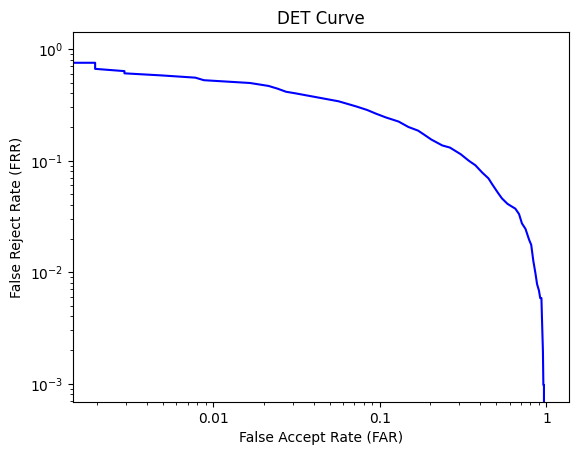

In [35]:
# Plotting the DET curve
plt.figure()
plt.plot(far, frr, linestyle='-', color='b')
plt.xscale('log')
plt.yscale('log')
plt.title('DET Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('False Reject Rate (FRR)')

plt.xticks([0.01, 0.1, 1], ['0.01', '0.1', '1'])

plt.show()